In [1]:
import os
import gc
import random
import copy
import time
from collections import defaultdict
import multiprocessing
from pathlib import Path
from copy import deepcopy

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torch.optim import lr_scheduler
from torchvision import datasets, models
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

In [2]:
CELL_TYPES = {
    'erythropoiesis': {
        'Proerythroblast': 'PEB',
        'Erythroblast': 'EBO',
    },
    'lymphoid': {
        'Immature Lymphocyte': 'LYI',
        'Lymphocyte': 'LYT',
        'Plasma Cell': 'PLM',
    },
    'myeloid': {
        'myeloid_immature': {
            'Myeloblast': 'BLA',
            'Metamyelocyte': 'MMZ',
            'Myelocyte': 'MYB',
            'Promyelocyte': 'PMO',
        },
        'myeloid_mature': {
            'Neutrophil': {
                'Band Neutrophil': 'NGB',
                'Segmented Neutrophil': 'NGS',
            },
            'Basophil': 'BAS',
            'Eosinophil': 'EOS',
            'Monocyte': 'MON',
        },
    },
    'abnormal': {
        'Not Identifiable': 'NIF',
        'Other Cell': 'OTH',
        'Abnormal Eosinophil': 'ABE',
        'Artefact': 'ART',
        'Smudge Cell': 'KSC',
        'Faggott Cell': 'FGC'
    }
}

def get_number_of_classes(class_map: dict, depth: int = -1):
    depth += 1
    print(' ' * 4 * depth + ' ' * 2 + str(len(class_map.keys())))
    for k, v in class_map.items():
        print(' ' * 4 * depth + str(k))
        if isinstance(v, dict):
            get_number_of_classes(v, depth)
    print(' ')

get_number_of_classes(CELL_TYPES)

  4
erythropoiesis
      2
    Proerythroblast
    Erythroblast
 
lymphoid
      3
    Immature Lymphocyte
    Lymphocyte
    Plasma Cell
 
myeloid
      2
    myeloid_immature
          4
        Myeloblast
        Metamyelocyte
        Myelocyte
        Promyelocyte
 
    myeloid_mature
          4
        Neutrophil
              2
            Band Neutrophil
            Segmented Neutrophil
 
        Basophil
        Eosinophil
        Monocyte
 
 
abnormal
      6
    Not Identifiable
    Other Cell
    Abnormal Eosinophil
    Artefact
    Smudge Cell
    Faggott Cell
 
 


# Extract from dataset

In [3]:
DATA_PATH = Path('./datasets/BM_cytomorphology_data/')
DATA_PATH

PosixPath('datasets/BM_cytomorphology_data')

In [4]:
IMAGE_FILE_TYPE = '.jpg'

def extract_class_names(class_map: dict, class_names: dict = dict()):
    for v in class_map.values():
        if isinstance(v, dict):
            class_names.update(extract_class_names(v, class_names))
        else:
            class_names[v] = set()
    return class_names

CLASS_PATHS = extract_class_names(CELL_TYPES)

for TYPE in DATA_PATH.iterdir():
    if CLASS_PATHS.get(TYPE.name, None) is not None:
        for path in TYPE.resolve().iterdir():
            if path.is_dir():
                for image in path.iterdir():
                    image_path = image.__str__()
                    if IMAGE_FILE_TYPE in image_path:
                        CLASS_PATHS[TYPE.name].add(image_path)
            else:
                image_path = path.__str__()
                if IMAGE_FILE_TYPE in image_path:
                    CLASS_PATHS[TYPE.name].add(image_path)

# DataSet summary

<BarContainer object of 20 artists>

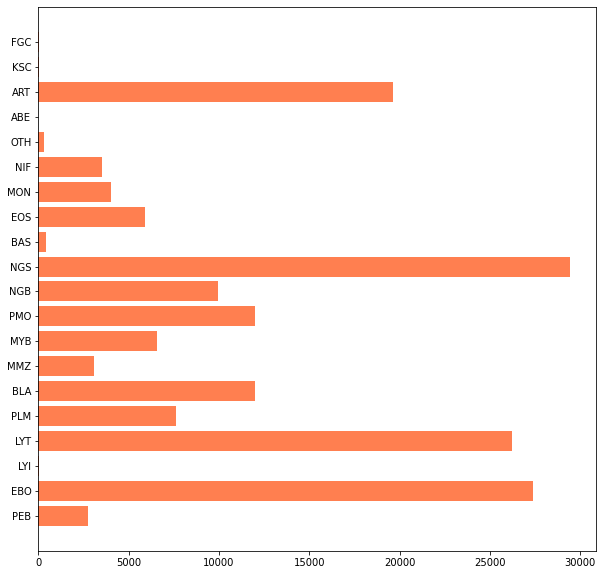

In [5]:
plt.figure(figsize=(10, 10))
plt.barh(list(CLASS_PATHS.keys()), [len(v) for v in CLASS_PATHS.values()], color='coral')

# Balancing and Preparing: Train, Validation and Test Samples

In [22]:
THRESHOLD_CLASS_SIZE = 1000
TEST_RATIO = 0.1
TRAIN_RATIO = 0.9
DEPTH_MAX = 2

def shuffle_dict(d):
    l = list(d.items())
    random.shuffle(l)
    return dict(l)

def slice_dict(d: dict, end: int, start: int = 0):
    keys = list(d.keys())
    if end == -1:
        end = len(keys)
    return {k: d[k] for k in keys[start:end]}

def prepare_nested_samples(class_map: dict, parent_name: str = 'root', depth: int = 0):
    result = {parent_name: {
        'train': dict(),
        'validation': dict(),
        'test': dict(),
    }}
    
    all_samples = dict()
    MIN_SIZE = None
    LABEL = 0
    label_map = dict()

    def pre_min_balancing(paths: dict, min_size: int) -> dict():
        if len(paths) >= THRESHOLD_CLASS_SIZE:
            if min_size is None or len(paths) < min_size:
                min_size = len(paths)
            paths = shuffle_dict(paths)
            p_balanced = slice_dict(paths, min_size)
            return p_balanced, min_size
        return dict(), min_size

    
    for k, v in class_map.items():
        if isinstance(v, dict):
            sub_result = prepare_nested_samples(
                class_map=v,
                parent_name=k,
                depth=depth+1
            )
            all_p = {p: LABEL for p in sub_result[k]['all']}
            labeled_paths, MIN_SIZE = pre_min_balancing(all_p, MIN_SIZE)
            if labeled_paths:
                all_samples[LABEL] = labeled_paths
                label_map[LABEL] = k
                result.update(sub_result)
                LABEL += 1
        else:
            paths = {p: LABEL for p in CLASS_PATHS[v]}
            labeled_paths, MIN_SIZE = pre_min_balancing(paths, MIN_SIZE)
            if labeled_paths:
                all_samples[LABEL] = labeled_paths
                label_map[LABEL] = k
                LABEL += 1

    # Slice samples.
    all_balanced = dict()
    print(list(label_map.keys()), parent_name, MIN_SIZE)
    for label, paths in all_samples.items():
        # Shuffle and slice.
        part = shuffle_dict(slice_dict(shuffle_dict(paths), MIN_SIZE))

        # Calculate sizes.
        test_size = int(len(part) * TEST_RATIO)
        train_size = int((len(part) - test_size) * TRAIN_RATIO)

        # Assign samples categories.
        train = slice_dict(part, train_size)
        validation = slice_dict(part, -test_size, train_size)
        test = slice_dict(part, -1, -test_size)
        result[parent_name]['train'].update(train)
        result[parent_name]['validation'].update(validation)
        result[parent_name]['test'].update(test)

        # Grab all.
        all_balanced.update(train)
        all_balanced.update(validation)
        all_balanced.update(test)
    
    # Additional info.
    result[parent_name]['label_map'] = label_map
    result[parent_name]['all'] = all_balanced
    result[parent_name]['class_number'] = MIN_SIZE
    result[parent_name]['depth'] = depth
    
    return result

PREPARED = prepare_nested_samples(CELL_TYPES)

[0, 1] erythropoiesis 2740
[0, 1] lymphoid 7629
[0, 1, 2, 3] myeloid_immature 3055
[0, 1] Neutrophil 9968
[0, 1, 2] myeloid_mature 4040
[0, 1] myeloid 12120
[0, 1] abnormal 3538
[0, 1, 2, 3] root 5480


# Full dataset preparation

In [7]:
# Augmentation pipeline
TRANSFORM = A.Compose([
    A.Rotate(p=0.8),
    A.RandomBrightnessContrast(p=0.6),
    A.RandomGamma(),
    A.Blur(p=0.2),
    A.Sharpen(),
    ToTensorV2(),
])

In [8]:
IMG_W = 256
IMG_H = 256
DIMENSION = (IMG_W, IMG_H)

class ModifiedDataset(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        # Get by index.
        image_path = list(self.paths.keys())[idx]
        image = cv2.imread(image_path)
        
        # Resize for unified size.
        image = cv2.resize(image, DIMENSION)
        
        # Convert to working color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Normilize image.
        image = np.float32(image/255)

        # Get image label
        label = self.paths[image_path]
        
        if self.transform is not None:
            image = self.transform(image=image)['image']
        return image, label

In [9]:
# DON'T DELETE!!!!!
# def visualize_augmentations(dataset, label_map, idx=0, samples=10, cols=5):
#     dataset = copy.deepcopy(dataset)
#     dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
#     rows = samples // cols
#     figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 5))
#     for i in range(samples):
#         image, label = dataset[idx]
#         ax.ravel()[i].imshow(image)
#         ax.ravel()[i].set_axis_off()
#     print('CLASS NAME: ', label_map[label])
#     plt.show()

# visualize_augmentations(
#     train_dataset,
#     DATASET['label_map'],
#     random.randint(0, len(DATASET['train']))
# )

# Training

In [10]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [11]:
def train(train_loader, model, criterion, optimizer, epoch):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (train_images, target) in enumerate(stream, start=1):
        # BATCH PREPARATION
        X = train_images.to(DEVICE, non_blocking=True)
        y = target.to(DEVICE, non_blocking=True).long()
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        y_preds = model(X)
        loss = criterion(y_preds, y)
        if i == len(train_loader):
            loss_save = loss.item()
        metric_monitor.update("Loss", loss.item())
        loss.backward()
        optimizer.step()
        
        # Output
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch+1, metric_monitor=metric_monitor)
        )
        
    return loss_save

In [12]:
def validate(val_loader, model, criterion, epoch):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (validation_images, target) in enumerate(stream, start=1):
            X = validation_images.to(DEVICE, non_blocking=True)
            y = target.to(DEVICE, non_blocking=True).long()
            y_preds = model(X)
            
            # LOSS
            loss = criterion(y_preds, y)
            if i == len(val_loader):
                loss_save = loss.item()
            metric_monitor.update("Loss", loss.item())

            stream.set_description(
                "Epoch: {epoch}. Validation.    {metric_monitor}".format(epoch=epoch+1, metric_monitor=metric_monitor)
            )
    return loss_save

In [13]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 32
NUM_WORKERS = 10

EPOCHS = 10

def inference(dataset, case_name: str = ''):
    modes = {
        'clean': {
            'pretrained': False,
            'transform': False,
        },
        'pretrained': {
            'pretrained': True,
            'transform': False,
        },
        'pretrained_augmentated': {
            'pretrained': True,
            'transform': True,
        },
    }
    
    NUM_CLASSES = len(dataset['label_map'])
    
    accuracy_summary = dict()
    
    if case_name != '':
        case_name = '_' + case_name
    
    for m in modes:
        pretrained = modes[m]['pretrained']
        ALL_MODELS = {
            'mobilenet': models.mobilenet_v3_large(pretrained=pretrained),
            'resnet': models.resnet34(pretrained=pretrained),
            'efficientnet': models.efficientnet_b2(pretrained=pretrained),
            'regnet': models.regnet_y_800mf(pretrained=pretrained),
        }
        # TODO(dmtgk): Now system works only with ResNet model.
        SELECTED = 'resnet'
        MODEL = ALL_MODELS[SELECTED]
    
        # Change last layer if pretrained mode.
        if pretrained:
            if SELECTED == 'mobilenet':
                arch = 'mobilenet_v3_large'
                inverted_residual_setting, last_channel = models.mobilenetv3._mobilenet_v3_conf(arch)
                MODEL.classifier[3] = nn.Linear(last_channel, NUM_CLASSES)
            elif SELECTED == 'resnet' or SELECTED == 'regnet':
                MODEL.fc = torch.nn.Linear(MODEL.fc.in_features, NUM_CLASSES)
            elif SELECTED == 'efficientnet':
                inverted_residual_setting = models.efficientnet._efficientnet_conf(width_mult=1.1, depth_mult=1.2)
                lastconv_input_channels = inverted_residual_setting[-1].out_channels
                lastconv_output_channels = 4 * lastconv_input_channels
                MODEL.classifier[1] = nn.Linear(lastconv_output_channels, NUM_CLASSES)
        MODEL.to(DEVICE)
        criterion = nn.CrossEntropyLoss().to(DEVICE)
        optimizer = optim.Adam(MODEL.parameters(), lr=0.0001)
        
        transform_selected = A.Compose([ToTensorV2()])
        if modes[m]['transform']:
            transform_selected = TRANSFORM
    
        train_dataset = ModifiedDataset(
            paths=dataset['train'],
            transform=transform_selected
        )
        val_dataset = ModifiedDataset(
            paths=dataset['validation'],
            transform=transform_selected
        )

        train_loader = DataLoader(
            train_dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=True,
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=True,
        )

        train_all_losses = list()
        val_all_losses = list()
        for epoch in range(EPOCHS):
            train_loss = train(train_loader, MODEL, criterion, optimizer, epoch)
            train_all_losses.append(train_loss)

            val_loss = validate(val_loader, MODEL, criterion, epoch)
            val_all_losses.append(val_loss)

        # Loss rate by epoch.
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(train_all_losses, label="Train Loss")
        ax.plot(val_all_losses, label="Validation Loss")
        ax.legend()
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss rate')
        plt.savefig(os.path.join('results', SELECTED + '_' + m + case_name + '.png'))
        
        # Test.
        test_transform = A.Compose([ToTensorV2()])
        test_dataset = ModifiedDataset(
            paths=dataset['test'],
            transform=test_transform
        )
        test_loader = DataLoader(
            test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True,
        )
        
        # Evaluate Test Data.
        model = MODEL.eval()
        correct = {label: 0 for label in dataset['label_map'].keys()}
        total = {label: 0 for label in dataset['label_map'].keys()}
        with torch.no_grad():
            for data in test_loader:
                test_images, labels = data
                test_images = test_images.to(DEVICE, non_blocking=True)
                labels = labels.to(DEVICE, non_blocking=True).long()
                outputs = model(test_images)
                _, predictions = torch.max(outputs, 1)

                # Count correct predictions for the each class.
                for label, prediction in zip(labels, predictions):
                    if label == prediction:
                        correct[label.item()] += 1
                    total[label.item()] += 1
        correct_summary = {dataset['label_map'][k]: v for k, v in correct.items()}
        total_summary = {dataset['label_map'][k]: v for k, v in total.items()}
        
        # Get accuracy for each class.
        accs = list()
        for classname, correct_count in correct_summary.items():
            predicted_count = total_summary[classname]
            if predicted_count == 0:
                predicted_count = 1
            accuracy = 100 * float(correct_count) / predicted_count
            accs.append(accuracy)
#             print("{:5s} {:.1f} %".format(classname, accuracy))
#         print(f"Total accuracy on all classes is {round(np.mean(accs), 2)} %")
        accuracy_summary[m] = np.mean(accs)
        
        # Free resources space.
        del MODEL
        gc.collect()
        torch.cuda.empty_cache()
    return accuracy_summary

In [ ]:
summary_table = pd.DataFrame()

for case in PREPARED.keys():
    mean_acc = inference(PREPARED[case], case)
    mean_acc.update({'case': case})
    summary_table = summary_table.append(pd.DataFrame([mean_acc]))

summary_table = summary_table.append(pd.DataFrame([{
    'clean': np.mean(summary_table['clean']),
    'pretrained': np.mean(summary_table['pretrained']),
    'pretrained_augmentated': np.mean(summary_table['pretrained_augmentated']),
    'case': 'all',
}]))

summary_table.to_csv('summary.tsv', sep='\t', index=False)

Epoch: 10. Validation.    Loss: 0.596: 100%|██████████| 62/62 [00:03<00:00, 17.69it/s]
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /home/aparfenenkova/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


Downloading: "https://download.pytorch.org/models/regnet_y_800mf-1b27b58c.pth" to /home/aparfenenkova/.cache/torch/hub/checkpoints/regnet_y_800mf-1b27b58c.pth


Epoch: 2. Train.      Loss: 0.062:  81%|████████  | 112/139 [00:13<00:03,  8.81it/s]